## CNN 모델 기반 영화 포스터를 통한 회원점수 예측 <hr>

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import random
import glob
from natsort import natsorted
import os

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchinfo import summary
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchviz import make_dot
from torchmetrics.functional import mean_squared_error, r2_score

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [348]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [349]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

### 데이터 전처리 <hr>

In [350]:
data_file = './DATA/movie_data.csv'

In [351]:
movieDF = pd.read_csv(data_file)
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9722 entries, 0 to 9721
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   포스터     9704 non-null   object 
 1   제목      9721 non-null   object 
 2   장르      9692 non-null   object 
 3   러닝타임    9605 non-null   object 
 4   회원점수    9691 non-null   object 
 5   줄거리     9691 non-null   object 
 6   제작비     5917 non-null   float64
 7   수익      902 non-null    object 
 8   감독      9690 non-null   object 
dtypes: float64(1), object(8)
memory usage: 683.7+ KB


In [352]:
movieDF.shape

(9722, 9)

In [353]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9722 entries, 0 to 9721
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   포스터     9704 non-null   object 
 1   제목      9721 non-null   object 
 2   장르      9692 non-null   object 
 3   러닝타임    9605 non-null   object 
 4   회원점수    9691 non-null   object 
 5   줄거리     9691 non-null   object 
 6   제작비     5917 non-null   float64
 7   수익      902 non-null    object 
 8   감독      9690 non-null   object 
dtypes: float64(1), object(8)
memory usage: 683.7+ KB


#### 중복 데이터 처리

In [354]:
# 중복 데이터 없음
movieDF = movieDF.drop_duplicates()
movieDF.shape

(9722, 9)

#### 결측 데이터 처리

In [355]:
# 제목 결측된 데이터는 한개=> 'non title(missing)'으로 수정
movieDF['제목'] = movieDF['제목'].fillna('non title(missing)')

In [356]:
# 제목 결측 데이터 없는지 확인
movieDF['제목'].isna().sum()

0

In [357]:
# 포스터 결측된 데이터 제거
movieDF.dropna(subset = ['포스터'], inplace = True)

In [358]:
# 포스터 결측 데이터 없는지 확인
movieDF['포스터'].isna().sum()

0

In [359]:
movieDF.shape

(9704, 9)

In [360]:
# movieDF의 shape[0]과 같은지 확인
len(glob.glob('./DATA/Poster image/*'))

9704

In [361]:
# 인덱스 순서대로 저장하기 위해 natsorted 사용
movieDF.insert(1, '이미지 경로', natsorted(glob.glob('./DATA/Poster image/*')))

In [363]:
movieDF.head(1)

,포스터,이미지 경로,제목,장르,러닝타임,회원점수,줄거리,제작비,수익,감독
0,https://media.themoviedb.org/t/p/w300_and_h450...,./DATA/Poster image\0.jpg,Dune: Part Two,"Science Fiction, Adventure",2h 47m,83.0,Follow the mythic journey of Paul Atreides as ...,666813734.0,NaN,Denis Villeneuve


In [364]:
movieDF['회원점수'].unique()

array(['83.0', '71.0', '67.0', '60.0', '51.0', '57.0', '68.0', '58.0',
       '69.0', '75.0', '49.0', '63.0', '78.0', '64.0', '66.0', '72.0',
       '81.0', '62.0', '76.0', '77.0', '59.0', '38.0', '65.0', '54.0',
       '40.0', '84.0', '73.0', '82.0', nan, '80.0', '55.0', '48.0',
       '74.0', '53.0', '56.0', '0.0', '42.0', '85.0', '50.0', '79.0',
       '70.0', '46.0', '87.0', '61.0', '52.0', '35.0', '47.0', '39.0',
       '86.0', '45.0', '100.0', '44.0', '10.0', '41.0', '43.0', '30.0',
       '90.0', '37.0', '20.0', '93.0', '36.0', '53', '50', '66', '70',
       '64', '54', '75', '71', '79', '0', '69', '65', '10', '74', '25',
       '62', '73', '55', '59', '60', '78', '63', '40', '68', '61', '57',
       '49', '42', '82', '67', '72', '56', '46', '76', '81', '80', '58',
       '43', '47', '51', '77', '52', '48', '39', '83', '37', '90', '23',
       '85',
       'The Best of Enemies,Centers on the unlikely relationship between Ann Atwater, an outspoken civil rights activist, and C.P. 

In [365]:
# # 회원점수가 잘못된 데이터 삭제
string = '''The Best of Enemies,Centers on the unlikely relationship between Ann Atwater, an outspoken civil rights activist, and C.P. Ellis, a local Ku Klux Klan leader who reluctantly co-chaired a community summit, battling over the desegregation of schools in Durham, North Carolina during the racially-charged summer of 1971. The incredible events that unfolded would change Durham and the lives of Atwater and Ellis forever.'''

movieDF = movieDF[movieDF['회원점수'] != string]

In [366]:
# 회원점수 데이터 float으로 타입변경
movieDF['회원점수'] = movieDF['회원점수'].astype('float')

In [367]:
# 회원점수 데이터 타입 변경 후 확인
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9703 entries, 0 to 9721
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   포스터     9703 non-null   object 
 1   이미지 경로  9703 non-null   object 
 2   제목      9703 non-null   object 
 3   장르      9680 non-null   object 
 4   러닝타임    9600 non-null   object 
 5   회원점수    9673 non-null   float64
 6   줄거리     9673 non-null   object 
 7   제작비     5917 non-null   float64
 8   수익      901 non-null    object 
 9   감독      9673 non-null   object 
dtypes: float64(2), object(8)
memory usage: 833.9+ KB


In [368]:
# 회원점수 결측된 데이터 제거
movieDF.dropna(subset = ['회원점수'], inplace = True)

In [369]:
movieDF['회원점수'].nunique()

70

In [370]:
# 포스터, 회원점수 결측 데이터 없는지 확인
movieDF[['포스터', '회원점수']].isna().sum()

포스터     0
회원점수    0
dtype: int64

####  이상 데이터 처리

In [371]:
movieDF['회원점수'].nunique()

70

In [372]:
movieDF['회원점수'].unique()

array([ 83.,  71.,  67.,  60.,  51.,  57.,  68.,  58.,  69.,  75.,  49.,
        63.,  78.,  64.,  66.,  72.,  81.,  62.,  76.,  77.,  59.,  38.,
        65.,  54.,  40.,  84.,  73.,  82.,  80.,  55.,  48.,  74.,  53.,
        56.,   0.,  42.,  85.,  50.,  79.,  70.,  46.,  87.,  61.,  52.,
        35.,  47.,  39.,  86.,  45., 100.,  44.,  10.,  41.,  43.,  30.,
        90.,  37.,  20.,  93.,  36.,  25.,  23.,  33.,  32.,  34.,  27.,
        15.,  95.,  29.,  28.])

In [373]:
data_nums = pd.cut(movieDF['회원점수'], bins = [i for i in range(0, 101, 10)], right = False)
data_nums.value_counts(sort = False)

회원점수
[0, 10)       136
[10, 20)        9
[20, 30)       12
[30, 40)       34
[40, 50)      303
[50, 60)     1650
[60, 70)     4177
[70, 80)     2970
[80, 90)      365
[90, 100)       7
Name: count, dtype: int64

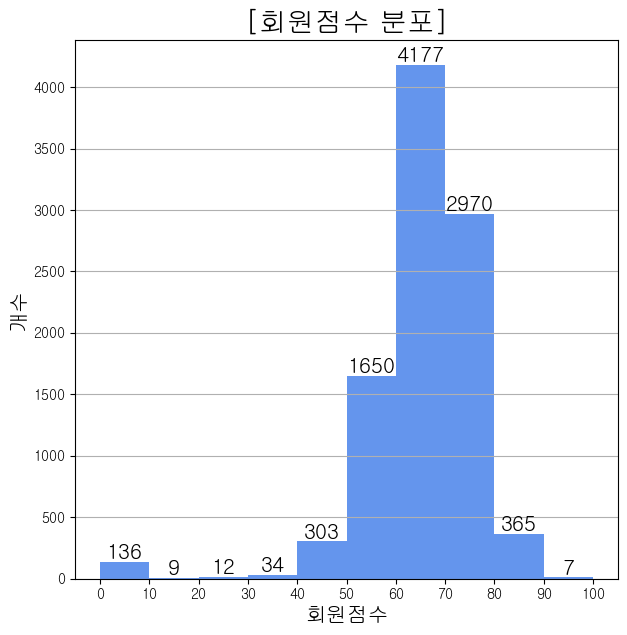

In [374]:
movieDF['회원점수'].hist(figsize = (7, 7), color = 'cornflowerblue', bins = [i for i in range(0, 101, 10)])
plt.title(f'[회원점수 분포]', size = 20)
plt.xlabel('회원점수', size = 15)
plt.xticks(np.arange(0, 101, 10), label = list(map(str, np.arange(0, 101, 10))))
plt.ylabel('개수', size = 15)
plt.grid(axis = 'x')

data_nums = pd.cut(movieDF['회원점수'], bins = [i for i in range(0, 101, 10)], right = False).value_counts(sort = False)
x = np.arange(5, 100, 10)
y = data_nums.values
for i in range(10):
    plt.text(x[i], y[i], y[i], fontsize = 15, color = 'black', horizontalalignment = 'center', verticalalignment = 'bottom')

plt.show()

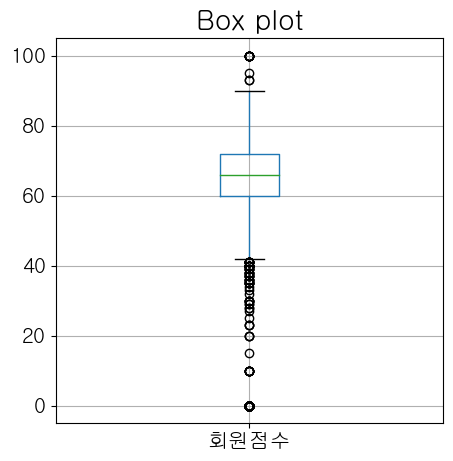

In [376]:
movieDF.boxplot(column = ['회원점수'], figsize = (5, 5), fontsize = 15)
plt.title('Box plot', size = 20)
plt.show()

In [377]:
# # Z-scroe 기반 이상치 탐지 함수
# def find_z_outlier(column_list, scale = 3, df = movieDF):
#     for col in column_list:
#         mean_value = df[col].mean()
#         std_value = df[col].std()
        
#         base = scale
#         z_data = (df[col] - mean_value) / std_value
#         mask = z_data.abs() > scale
#         print(f'{col} 특성의 Z_score 기반 이상치 개수 : {z_data[mask].count()}개\n')

In [378]:
# find_z_outlier(['회원점수'])

In [379]:
# # Z-score 기반 이상치 제거 함수
# def delete_z_outlier(column_list, scale = 3, df = movieDF):
#     del_index_list = []
#     for col in column_list:
#         mean_value = df[col].mean()
#         std_value = df[col].std()
#         base = scale
#         z_data = (df[col] - mean_value) / std_value
#         mask = z_data.abs() > base
#         index_list = list(df[mask].index)
#         del_index_list += index_list
    
#     del_index_list = list(set(del_index_list))
#     df = df.drop(del_index_list)
#     df.reset_index(drop = True, inplace = True)
    
#     return df

In [380]:
# # Z-score 기반 이상치 제거 후 확인
# movieDF = delete_z_outlier(['회원점수'])
# movieDF.shape

In [381]:
# 사분위수 기반 이상치 탐지 함수
def find_q_outlier(column_list, scale = 1.5, df = movieDF):
    for col in column_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # 이상치로 판단할 기준이 되는 값
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[col] < lower) | (df[col] > upper) 
        
        print(f'{col} 특성의 사분위수 기반 이상치 개수 : {df[col][mask].count()}개\n')

In [382]:
find_q_outlier(['회원점수'])

회원점수 특성의 사분위수 기반 이상치 개수 : 227개



In [383]:
# 사분위수 기반 이상치 제거 함수
def delete_q_outlier(column_list, scale = 1.5, df = movieDF):
    del_index_list = []
    for column in column_list:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[column] > upper) | (df[column] < lower)
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [384]:
# 사분위수 기반 이상치 제거 후 확인
movieDF = delete_q_outlier(['회원점수'])
movieDF.shape

(9446, 10)

In [385]:
movieDF['회원점수'].nunique()

47

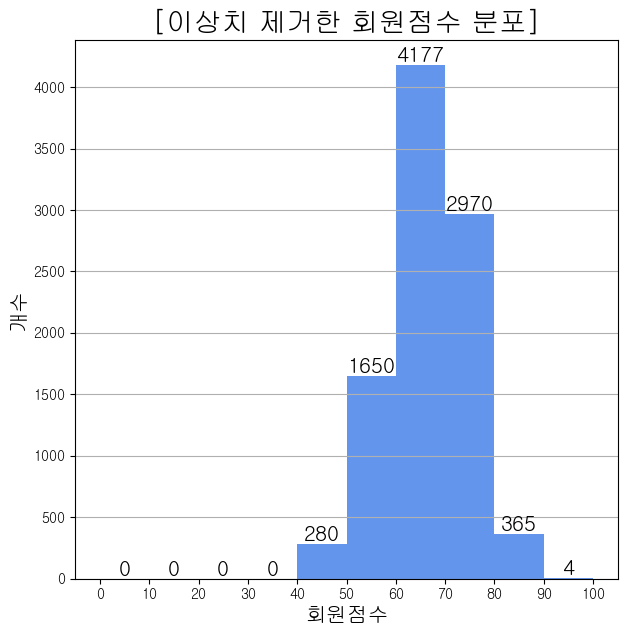

In [386]:
# 이상치 제거후 회원점수 분포
movieDF['회원점수'].hist(figsize = (7, 7), color = 'cornflowerblue', bins = [i for i in range(0, 101, 10)])
plt.title(f'[이상치 제거한 회원점수 분포]', size = 20)
plt.xlabel('회원점수', size = 15)
plt.xticks(np.arange(0, 101, 10), label = list(map(str, np.arange(0, 101, 10))))
plt.ylabel('개수', size = 15)
plt.grid(axis = 'x')

data_nums = pd.cut(movieDF['회원점수'], bins = [i for i in range(0, 101, 10)], right = False).value_counts(sort = False)
x = np.arange(5, 100, 10)
y = data_nums.values
for i in range(10):
    plt.text(x[i], y[i], y[i], fontsize = 15, color = 'black', horizontalalignment = 'center', verticalalignment = 'bottom')

plt.show()

#### 학습 데이터 준비

In [387]:
# jpg 포스터가 아닌 데이터는 삭제
ind = 0
for poster in movieDF['이미지 경로'].values:
    if os.path.splitext(poster)[1] != '.jpg':
        movieDF.drop(ind, inplace = True)
    ind += 1

In [388]:
# jpg 형식이 아닌 포스터 없음
movieDF.shape

(9446, 10)

In [389]:
movieDF.reset_index(drop = True, inplace = True)

In [390]:
# 컬러 포스터가 아닌 데이터는 삭제
ind = 0
for poster in movieDF['이미지 경로'].values:
    if np.array(Image.open(poster)).ndim != 3:
        movieDF.drop(ind, inplace = True)
    ind += 1

In [391]:
# 컬러 포스터가 아닌 데이터 28개 삭제
movieDF.shape

(9418, 10)

In [392]:
movieDF.reset_index(drop = True, inplace = True)

In [393]:
# 흑백이미지 존재 여부 확인 => 없음
for poster in movieDF['이미지 경로'].values:
    if np.array(Image.open(poster)).ndim != 3:
        print('2차원 이미지')

In [394]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 데이터셋의 평균값
                         std=[0.229, 0.224, 0.225])]) # ImageNet 데이터셋의 표준편차 std=[0.229, 0.224, 0.225]

In [395]:
my_data = torch.empty((1, 3, 64, 64))
for poster in movieDF['이미지 경로'].values:
    image = Image.open(poster)
    preprocessed_image = transform(image).unsqueeze(0)
    my_data = torch.cat((my_data, preprocessed_image), 0)

In [396]:
# empty tensor는 제외
my_data = my_data[1:]
my_data.size()

torch.Size([9418, 3, 64, 64])

In [397]:
# 클래스 정의
class MovieDS(Dataset):

    # 필요한 데이터 전처리 수행도 가능 => 정규화 등
    def __init__(self, x_data, y_data):
        super().__init__()
        # x, y 데이터 => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.Series) else y_data
        
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.FloatTensor(y_data)
        self.length = self.feature.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [398]:
MY_DATASET = MovieDS(my_data, movieDF['회원점수'])

In [399]:
# 학습용, 검증용, 테스트 데이터 비율
seed = torch.Generator().manual_seed(42)

trainDS, validDS, testDS = random_split(MY_DATASET, [0.7, 0.1, 0.2], generator = seed)

print(f'trainDS =>{len(trainDS)}개, validDS => {len(validDS)}개, testDS => {len(testDS)}개')

print(f'Subset 속성 =>\nindices : {trainDS.indices} \nindices : {trainDS.dataset}')
print(f'Subset 속성 =>\nindices : {validDS.indices} \nindices : {validDS.dataset}')
print(f'Subset 속성 =>\nindices : {testDS.indices} \nindices : {testDS.dataset}')

trainDS =>6593개, validDS => 942개, testDS => 1883개
Subset 속성 =>
indices : [5470, 5304, 814, 8632, 4, 6699, 1406, 8463, 8858, 2123, 668, 6510, 1290, 4747, 4057, 5909, 8337, 5042, 4185, 155, 2783, 3046, 5099, 459, 4493, 323, 7583, 1600, 3575, 8761, 6874, 736, 973, 9317, 183, 4977, 2477, 7815, 6050, 3801, 3822, 1690, 4595, 8812, 4355, 6195, 249, 206, 7241, 942, 3112, 479, 3998, 3332, 8372, 6842, 6273, 7764, 3996, 8284, 606, 7015, 7922, 3683, 9262, 3503, 8477, 5729, 6629, 7706, 6087, 7007, 6446, 1016, 9086, 6121, 8251, 8282, 5956, 600, 8354, 257, 9246, 741, 5784, 8835, 3483, 3284, 6063, 4351, 5217, 4920, 4353, 9182, 8471, 5955, 2921, 2009, 1119, 7174, 80, 8845, 4479, 9198, 3787, 2871, 5671, 1286, 2273, 2524, 1381, 908, 6157, 3919, 7224, 4086, 5472, 201, 4729, 3055, 2737, 683, 5115, 954, 3092, 1464, 2483, 3009, 887, 2305, 1325, 5632, 3588, 3758, 6132, 931, 840, 669, 7248, 6494, 1793, 755, 2013, 3387, 3861, 3294, 2852, 5058, 4316, 7659, 7292, 8226, 4580, 2891, 4894, 1421, 4248, 5021, 3038, 80

In [400]:
# DataLoader 생성
# drop_last 매개변수 : 배치 사이즈로 데이터셋 분리 후 남는 데이터 처리 방법 설정 [기본 : False]
BATCH_SIZE = 128
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE, drop_last = True)
validDL = DataLoader(validDS, batch_size = BATCH_SIZE, drop_last = True)
testDL = DataLoader(testDS, batch_size = BATCH_SIZE, drop_last = True)

# Epoch당 반복 단위
print(f'batch_size = {BATCH_SIZE}')
print(f'trainDS => {len(trainDS)}개, validDS => {len(validDS)}개, testDS => {len(testDS)}개')
print(f'trainDL => {len(trainDL)}개, validDL => {len(validDL)}개, testDL => {len(testDL)}개')

batch_size = 128
trainDS => 6593개, validDS => 942개, testDS => 1883개
trainDL => 51개, validDL => 7개, testDL => 14개


In [401]:
for feature, target in enumerate(trainDL):
    print(feature, target)
    break

0 [tensor([[[[-1.4329, -1.6727, -1.7925,  ..., -1.8439, -1.8782, -1.8953],
          [-1.4329, -1.6898, -1.8610,  ..., -1.8097, -1.8268, -1.8439],
          [-1.5528, -1.8439, -2.0494,  ..., -1.7925, -1.7925, -1.8097],
          ...,
          [-0.6281,  0.0056,  0.3994,  ...,  0.6221,  0.7248,  0.7762],
          [-1.0219, -0.9877,  0.0741,  ...,  0.5022,  0.5536,  0.5707],
          [-0.2856, -0.0458,  0.2624,  ...,  0.5878,  0.6049,  0.6563]],

         [[-0.7227, -0.8452, -0.8102,  ..., -1.0378, -1.0728, -1.0903],
          [-0.6702, -0.7402, -0.7227,  ..., -0.9328, -0.9853, -1.0028],
          [-0.6527, -0.6877, -0.6352,  ..., -0.8102, -0.8627, -0.8978],
          ...,
          [ 0.2402,  1.0280,  1.4307,  ...,  1.4657,  1.5182,  1.5707],
          [-0.1450, -0.2150,  1.0805,  ...,  1.3957,  1.4307,  1.4482],
          [ 0.9055,  1.0455,  1.3431,  ...,  1.4132,  1.4307,  1.4657]],

         [[-0.0964,  0.0953,  0.3219,  ..., -0.0964, -0.1312, -0.1661],
          [ 0.0605,  0.3045

In [425]:
# resnet18 모델 인스턴스 생성
MY_MODEL = resnet18()

# 전결합층 변경
# in feature : FeatureMap에서 받은 피처 수, out_featrues : 출력/분류 클래스 수
MY_MODEL.fc = nn.Sequential(nn.Linear(512, 128),
              nn.BatchNorm1d(num_features = 128),
              nn.ReLU(),
              nn.Dropout(),
              nn.Linear(128, 32),
              nn.BatchNorm1d(num_features = 32),
              nn.ReLU(),
              nn.Dropout(),
              nn.Linear(32, 1))

In [426]:
# 각 fully connected layer에 He initialization 적용
for layer in MY_MODEL.modules():
    if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_normal_(layer.weight.data)
        torch.nn.init.zeros_(layer.bias.data)
    elif isinstance(layer, nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight.data)

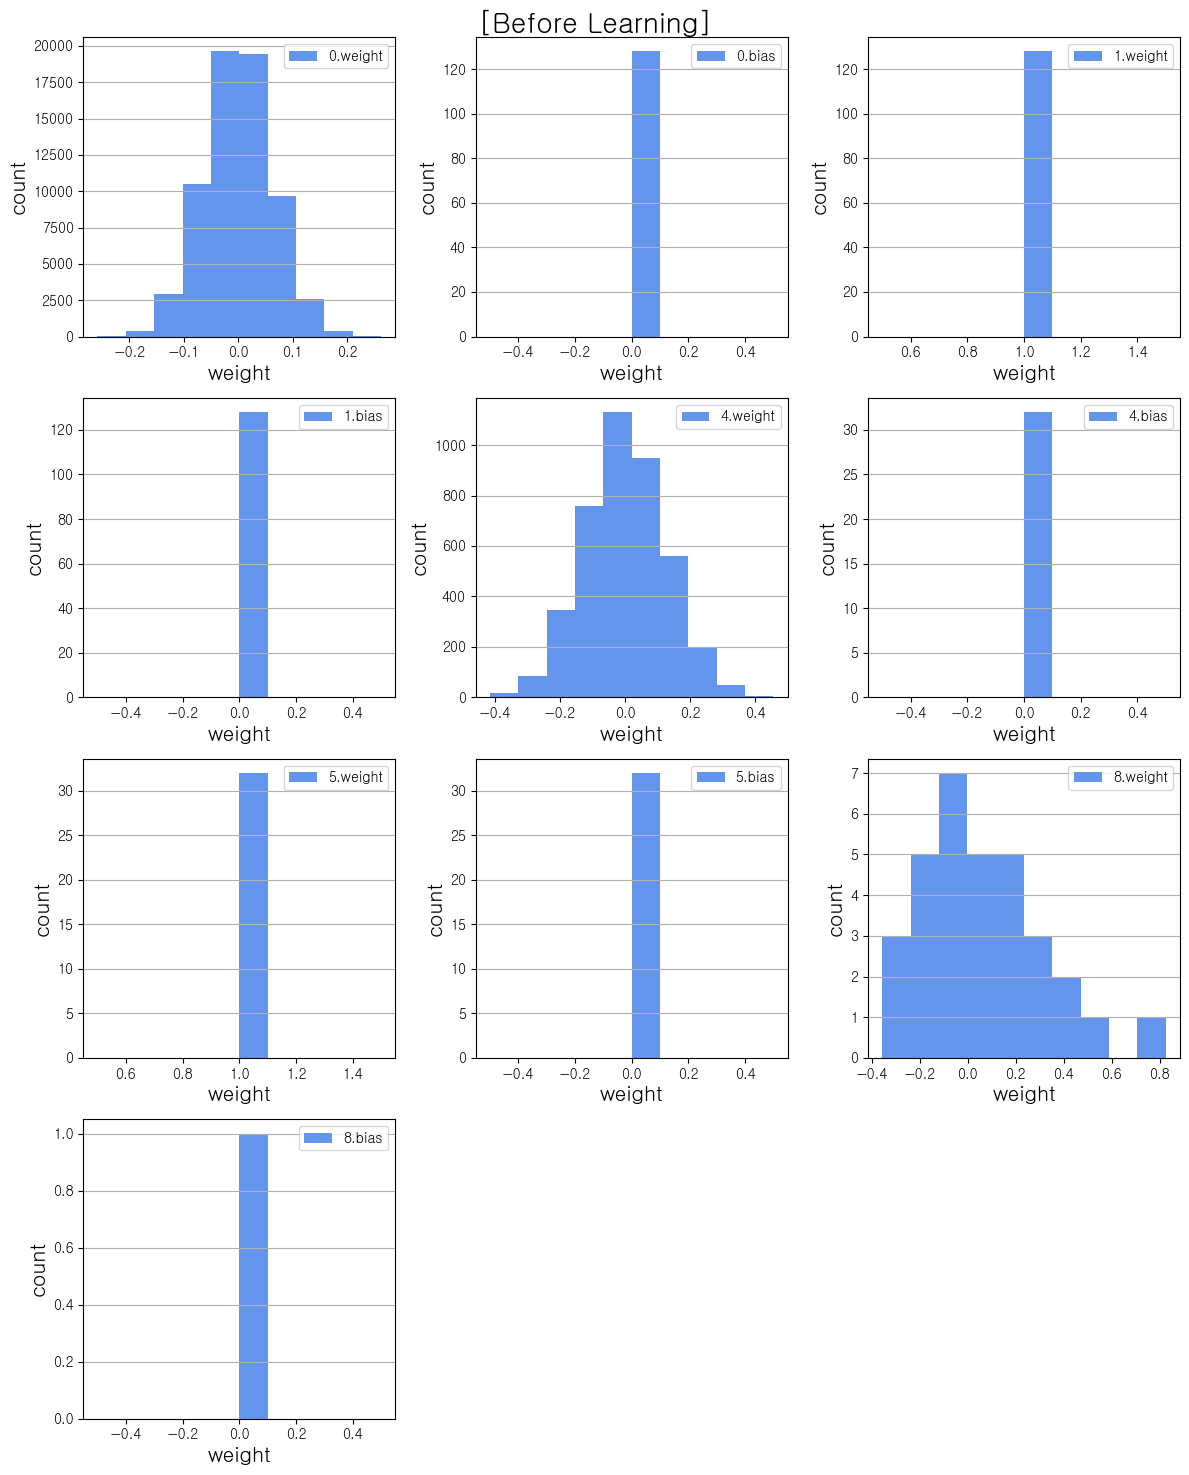

In [428]:
plt.figure(figsize = (12, 15))
plt.suptitle('[Before Learning]', size = 20)
i = 1
for name, params in MY_MODEL.fc.named_parameters():
    plt.subplot(4, 3, i)
    plt.hist(params.detach().numpy().flatten(), label = name, color = 'cornflowerblue')
    plt.xlabel('weight', size = 15)
    plt.ylabel('count', size = 15)
    plt.grid(axis = 'y')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

In [66]:
# # Resnet18 Feature Module 파라미터 requires_grad = True => False 비활성화
# for name, param in res_model.named_parameters():
#     print(name, param.requires_grad, end = '     =====>     ')
#     param.requires_grad = False
#     print(param.requires_grad)

# for name, param in res_model.fc.named_parameters():
#     print(name, param.requires_grad, end = '     =====>     ')
#     param.requires_grad = True
#     print(param.requires_grad)

In [429]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.2  Device: cpu


In [430]:
# 학습 준비
OPTIMIZER = optim.Adam(params = MY_MODEL.parameters(), lr = 0.01)  # lr default = 0.001
LOSS_FN = nn.MSELoss()  # 손실 함수 정의
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 10)

In [431]:
### ===> 학습 진행함수 
def training():
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    MY_MODEL.train()
    
    # 배치크기 만큼 학습 진행 및 저장
    train_report=[[], []]
    for idx, (feature, target) in enumerate(trainDL):
        # 배치크기만큼의 학습 데이터 준비
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_traget = MY_MODEL(feature)
        target = target.unsqueeze(1)
        
        # 손실계산
        loss = LOSS_FN(pre_traget, target)
        train_report[0].append(loss.item())
        
        # 성능 평가
        train_r2 = r2_score(pre_traget, target)
        train_report[1].append(train_r2.item())
        
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
    
    # 에포크 단위로 학습 모델 저장
    # torch.save(model, './model/MY_MODEL.pt')
    
    # 에포크 단위 학습 진행 메시지 출력
    train_loss = np.mean(train_report[0])
    train_r2score = np.mean(train_report[1])

    #print(f'\n[{epoch+1} Train ] Loss ==> {train_loss:.4f} Accuracy ==> {train_accuracy:.2f}\n')
    
    return train_loss, train_r2score

In [432]:
### ===> 검증 및 테스트 진행함수 
def evaluating():
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    MY_MODEL.eval()
        
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장
        valid_report=[[], []]
        for idx, (feature, target) in enumerate(validDL):
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)
        
            # 학습
            pre_traget = MY_MODEL(feature)
            target = target.unsqueeze(1)
        
            # 손실계산
            loss = LOSS_FN(pre_traget, target)
            valid_report[0].append(loss)
            
            # 성능 평가 
            val_r2 = r2_score(pre_traget, target)
            valid_report[1].append(val_r2)

    #testing_type = 'Valid' if kind == 'valid' else 'Test'
        
    # 에포크 단위 학습 진행 메시지 출력
    val_loss = np.mean(valid_report[0])
    val_r2score = np.mean(valid_report[1])

    #print(f'[{epoch+1} {testing_type} ] Loss ==> {valid_loss:.4f} Acc ==> {valid_accuarcy:.2f}\n')
    
    return val_loss, val_r2score

In [433]:
EPOCHS = 100
loss_list = [[], []]
r2score_list = [[], []]

for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_r2_score = training()
    val_loss, val_r2_score = evaluating()
    
    print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain R2 Score: {train_r2_score:.2f}\n")
    print(f"\n[EPOCH: {epoch}], \tVal Loss: {val_loss:.4f}, \tVal R2 Score: {val_r2_score:.2f}\n")

    loss_list[0].append(train_loss)
    loss_list[1].append(val_loss)
    r2score_list[0].append(train_r2_score)
    r2score_list[1].append(val_r2_score)

    # SCHEDULER.step(val_loss)
    # if epoch >= 50:
    #     # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
    #     if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
    #         print(f'Early stopping at epoch {epoch}')
    #         break


[EPOCH: 1], 	Train Loss: 3511.6230, 	Train R2 Score: -53.05


[EPOCH: 1], 	Val Loss: 2152.9126, 	Val R2 Score: -32.97


[EPOCH: 2], 	Train Loss: 1251.4182, 	Train R2 Score: -18.17


[EPOCH: 2], 	Val Loss: 308.4225, 	Val R2 Score: -3.85


[EPOCH: 3], 	Train Loss: 317.2747, 	Train R2 Score: -3.87


[EPOCH: 3], 	Val Loss: 247.4469, 	Val R2 Score: -2.87


[EPOCH: 4], 	Train Loss: 262.1967, 	Train R2 Score: -3.03


[EPOCH: 4], 	Val Loss: 98.3141, 	Val R2 Score: -0.54


[EPOCH: 5], 	Train Loss: 252.3577, 	Train R2 Score: -2.86


[EPOCH: 5], 	Val Loss: 89.1713, 	Val R2 Score: -0.39


[EPOCH: 6], 	Train Loss: 241.1906, 	Train R2 Score: -2.70


[EPOCH: 6], 	Val Loss: 85.7754, 	Val R2 Score: -0.34


[EPOCH: 7], 	Train Loss: 241.8886, 	Train R2 Score: -2.72


[EPOCH: 7], 	Val Loss: 95.7072, 	Val R2 Score: -0.49


[EPOCH: 8], 	Train Loss: 234.0489, 	Train R2 Score: -2.60


[EPOCH: 8], 	Val Loss: 99.6444, 	Val R2 Score: -0.57


[EPOCH: 9], 	Train Loss: 236.7944, 	Train R2 Score: -2.64


[EPOCH: 9]

In [434]:
torch.save(MY_MODEL, './Models/ResNet18_Member_Score4.pt')

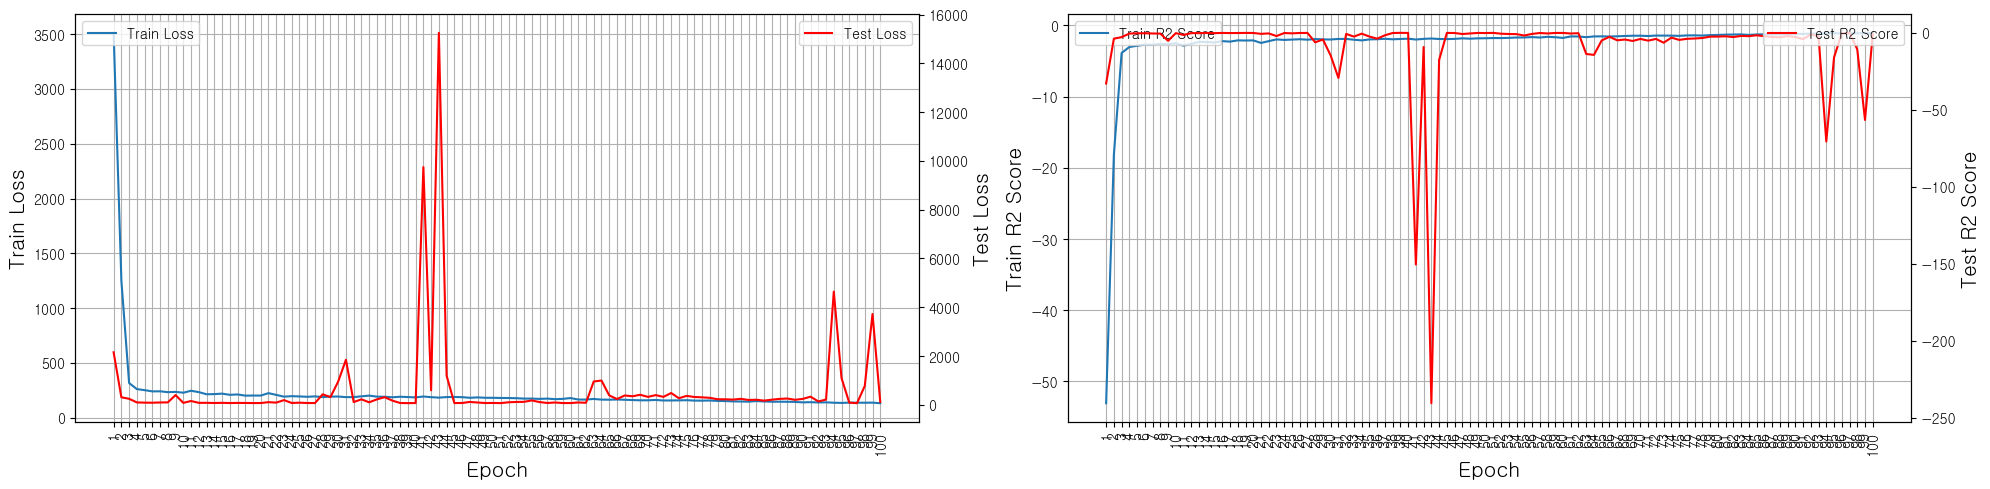

In [435]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Epoch", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(EPOCHS))
axes[0].set_xticklabels(np.arange(1, EPOCHS + 1), rotation = 90)
#axes[0].tick_params(rotation = 30)
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Test Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Loss", size = 15)

axes[1].plot(r2score_list[0], label = "Train R2 Score")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Epoch", size = 15)
axes[1].set_ylabel("Train R2 Score", size = 15)
axes[1].set_xticks(np.arange(EPOCHS))
axes[1].set_xticklabels(np.arange(1, EPOCHS + 1), rotation = 90)
#axes[1].tick_params(rotation = 30)
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(r2score_list[1], label = "Test R2 Score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test R2 Score", size = 15)

plt.tight_layout()
plt.show()

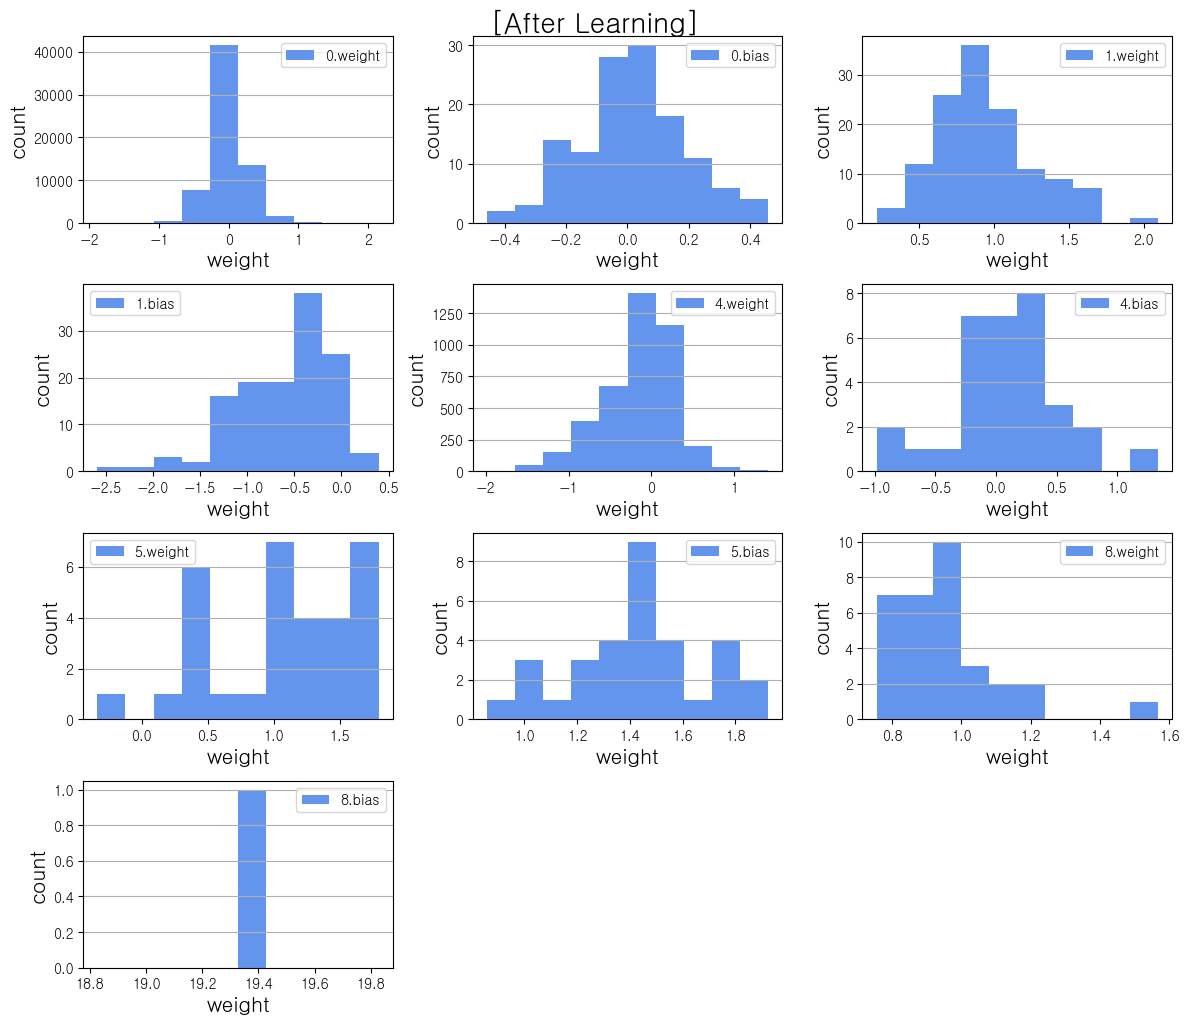

In [436]:
plt.figure(figsize = (12, 15))
plt.suptitle('[After Learning]', size = 20)
i = 1
for name, params in MY_MODEL.fc.named_parameters():
    plt.subplot(6, 3, i)
    plt.hist(params.detach().numpy().flatten(), label = name, color = 'cornflowerblue')
    plt.xlabel('weight', size = 15)
    plt.ylabel('count', size = 15)
    plt.grid(axis = 'y')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

In [437]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(MY_MODEL.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [438]:
type(list(MY_MODEL.children())[0])

torch.nn.modules.conv.Conv2d

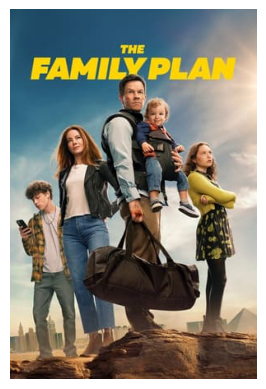

In [439]:
image = Image.open('./DATA/Poster image/91.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [440]:
preprocessing = transforms.Compose([transforms.Resize(size = (64, 64)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                                          std = (0.229, 0.224, 0.225))])

In [441]:
image = preprocessing(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(DEVICE)

Image shape before: torch.Size([3, 64, 64])
Image shape after: torch.Size([1, 3, 64, 64])


In [442]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])


In [443]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(4, 4)
(4, 4)
(4, 4)
(4, 4)


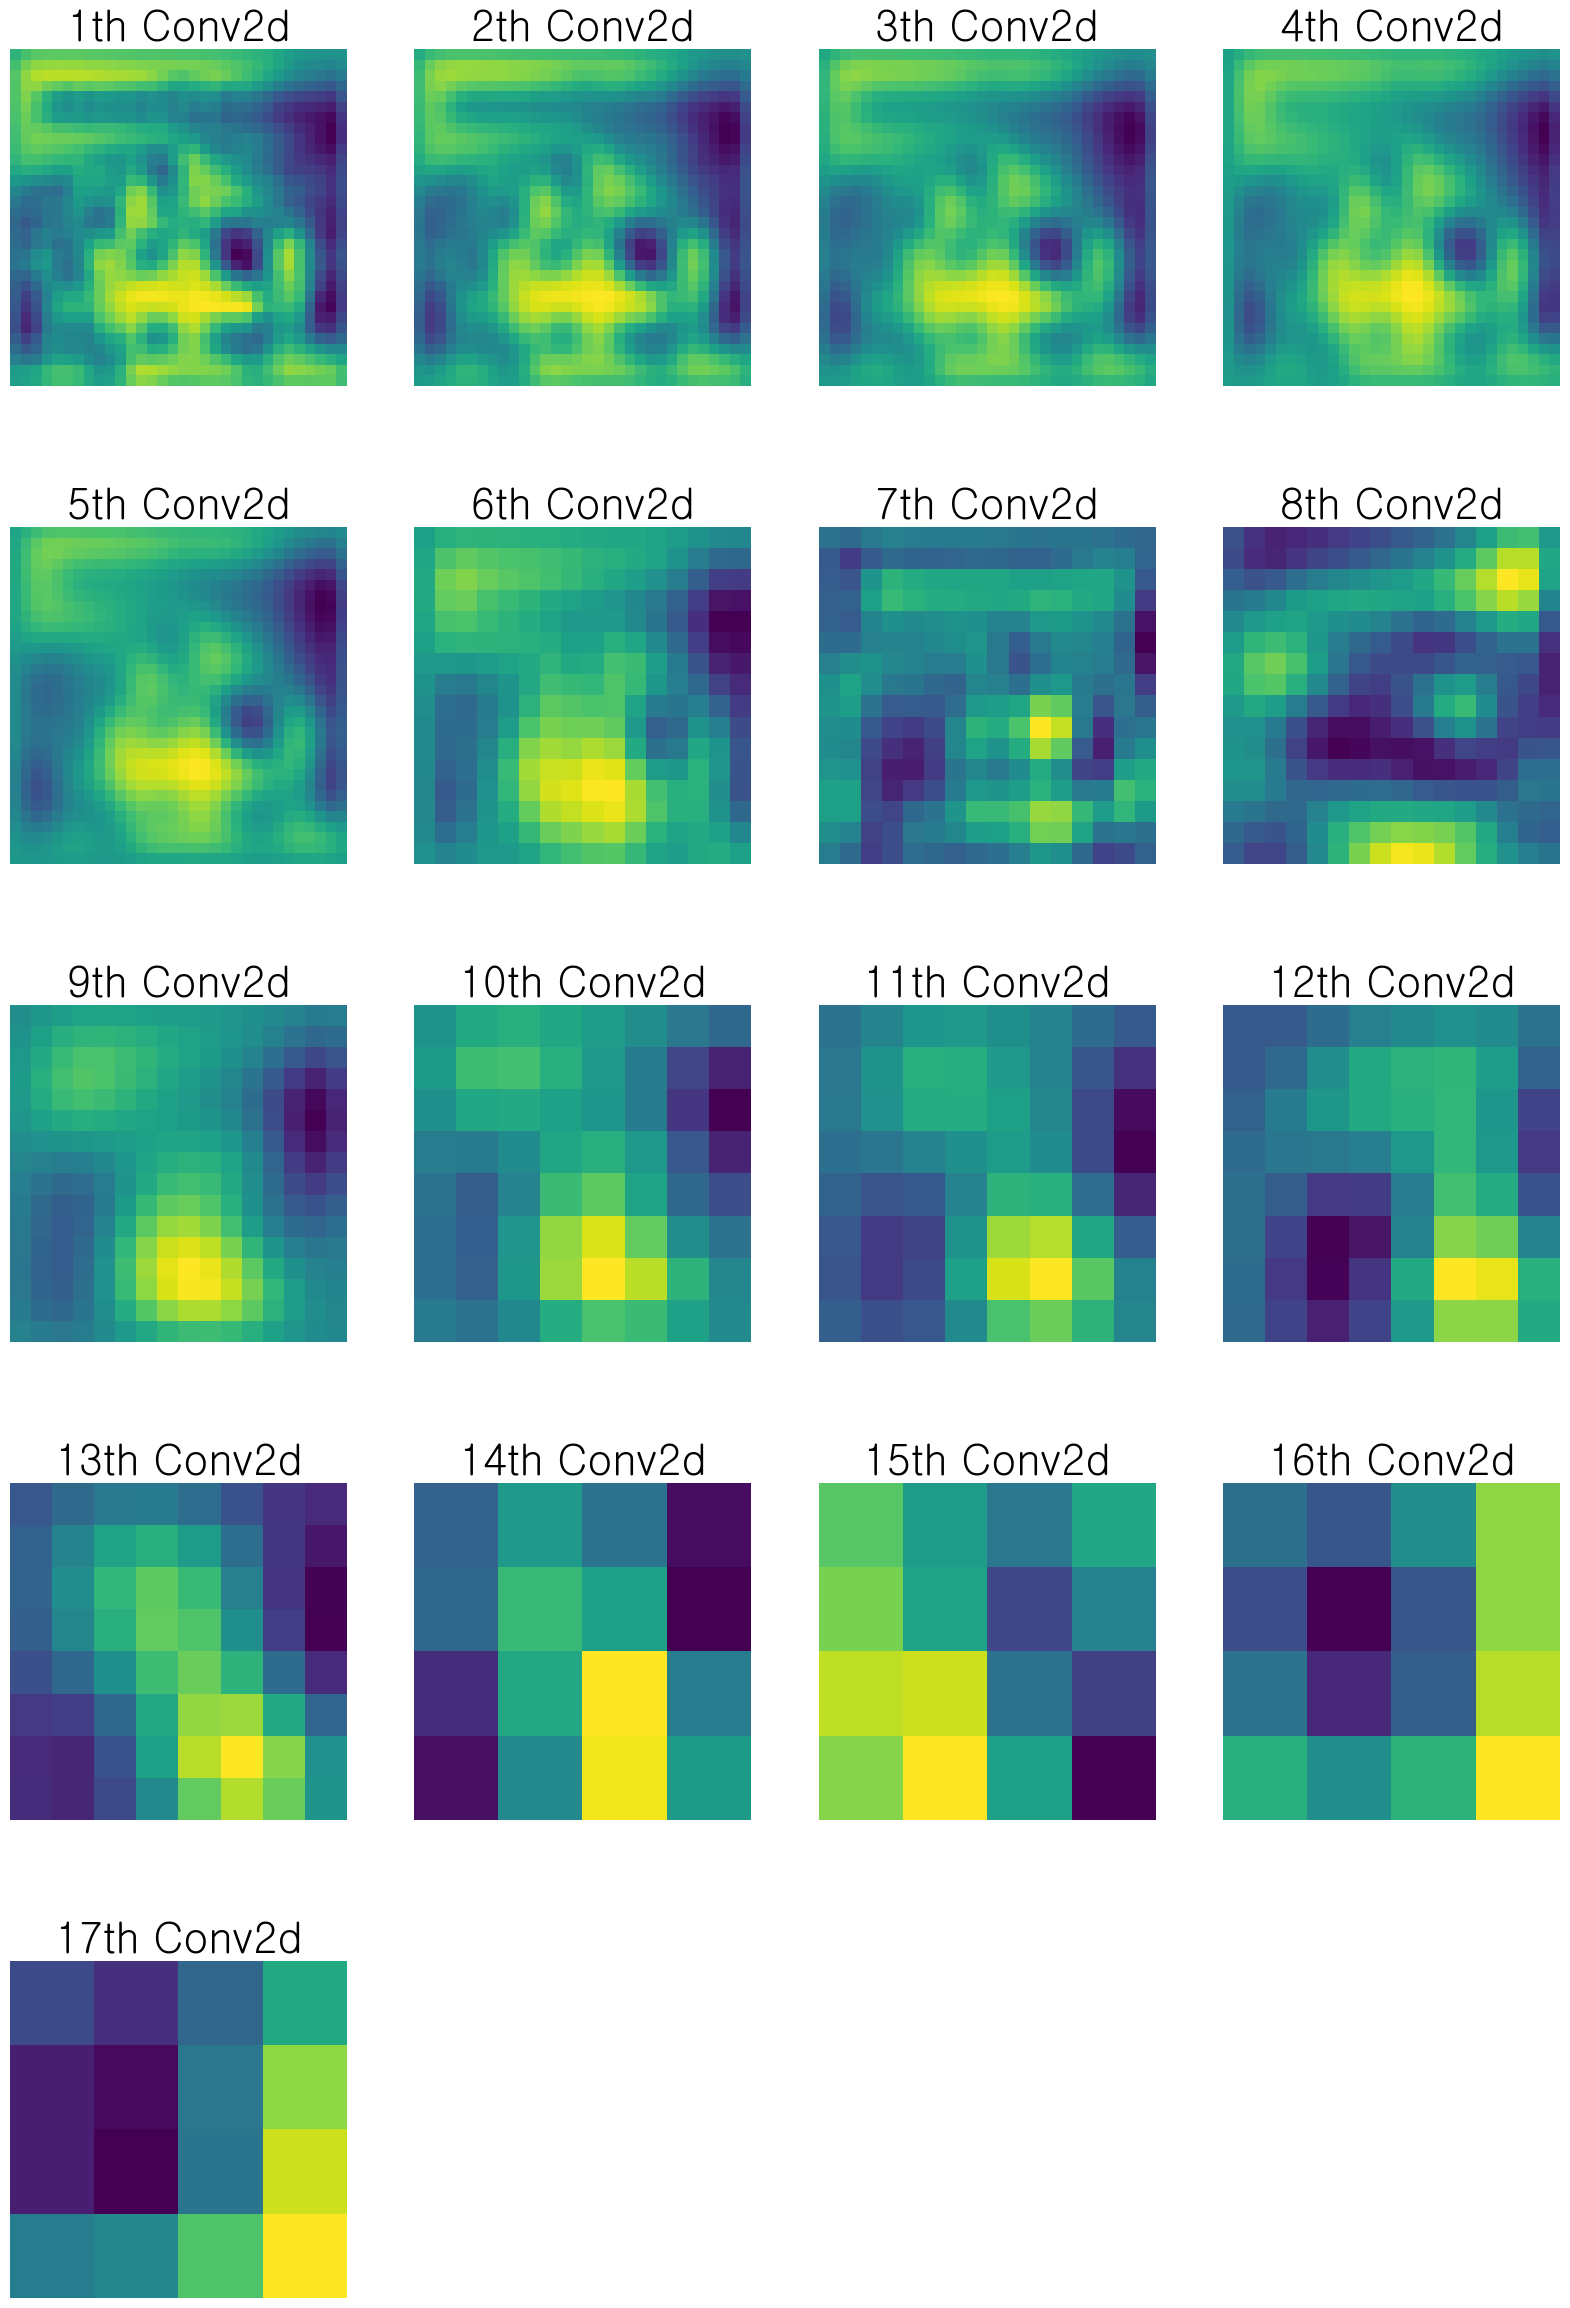

In [444]:
fig = plt.figure(figsize=(20, 30))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(f"{i+1}th {names[i].split('(')[0]}", fontsize=30)

In [445]:
movieDF.sample(3, random_state=42)['이미지 경로']

7481    ./DATA/Poster image\7737.jpg
624      ./DATA/Poster image\649.jpg
7275    ./DATA/Poster image\7525.jpg
Name: 이미지 경로, dtype: object

In [446]:
movieDF.sample(3, random_state = 42)['이미지 경로'].iloc[2]

'./DATA/Poster image\\7525.jpg'

In [447]:
def predict(number, random_state = None, df = movieDF, model = MY_MODEL):
    df = df.sample(number, random_state = random_state)
    image_path = df['이미지 경로']
    plt.figure(figsize = (10, 5))
    for ind in range(number):
        plt.subplot(1, number, ind+1)
        image = Image.open(image_path.iloc[ind])
        plt.imshow(image)
        plt.axis('off')
        image = preprocessing(image)
        with torch.no_grad():
            output = model(image.unsqueeze(0))
        score = df[df['이미지 경로'] == image_path.iloc[ind]]['회원점수'].values
        title = df[df['이미지 경로'] == image_path.iloc[ind]]['제목'].values
        print(f'영화 {title} 포스터에 대한 예측 회원 점수는 {round(output.item(), 1)}점\n실제 회원 점수는 {score.item()}점\n\n')
    plt.tight_layout()
    plt.show()

영화 ['Enola Holmes'] 포스터에 대한 예측 회원 점수는 65.1점
실제 회원 점수는 73.0점


영화 ['Amar Singh Chamkila'] 포스터에 대한 예측 회원 점수는 65.4점
실제 회원 점수는 87.0점


영화 ['Chinese Zodiac'] 포스터에 대한 예측 회원 점수는 64.5점
실제 회원 점수는 62.0점




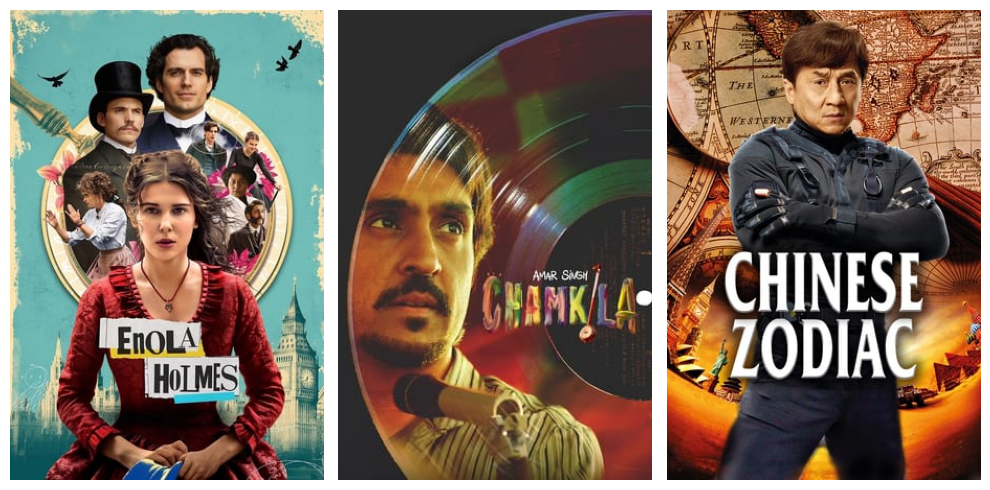

In [448]:
predict(3)

In [449]:
tf = transforms.ToPILImage()
img_t = tf(trainDS[0][0])
img_t.show()